# Evaluate total water witdrawal per country



In [1]:
import os
import xarray as xr
import pickle as pk
import time
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.colors as colors
import mapclassify as mc
from copy import deepcopy as cp
scriptsdir = os.getcwd()
from settings import *
from load_manip import *
from exposure import * 
from plotting import *
%matplotlib inline 

import cartopy.crs as ccrs
import cartopy.feature as cfeature

set_plot_param()
init()
labelfontsize=20
titlesize=24
labelsize=titlesize
mpl.rc('xtick',labelsize=labelfontsize)
mpl.rc('ytick',labelsize=labelfontsize)
mpl.rc('axes',titlesize=titlesize)
mpl.rc('axes',labelsize=20)
mpl.rc('legend',fontsize='large')

map_proj = ccrs.Robinson(central_longitude=0, globe=None)

## 1. Calculate withdrawal per country

## 2. Flags

In [2]:
def init(): 

    # Initialise based on ISIMIP phase
    global phase
    
    phase = '2b'
    
    # initialise age and associated time period of interest
    global ages, age_young, age_ref, age_range, year_ref, year_start, birth_years, year_end, year_range
    ages        = np.arange(60,-1,-1)
    age_young   = 0
    age_ref     = np.nanmax(ages)
    age_range   = np.arange(0,105)
    year_ref    = 2020
    year_start  = year_ref - age_ref
    birth_years = np.arange(year_start,year_ref+1)     
    year_end    = 2113                            # based on maximum life expectancy reported in UN WPP
    year_range  = np.arange(year_start,year_end+1)


    # initialise age groups
    # (https://www.carbonbrief.org/analysis-why-children-must-emit-eight-times-less-co2-than-their-grandparents)
    # (https://www.pewresearch.org/fact-tank/2019/01/17/where-millennials-end-and-generation-z-begins/)
    global agegroups
    agegroups = {
        'Boomers' : (1950, 1965),
        'Gen X' : (1965, 1981),
        'Millenials' : (1981, 1997),
        'Gen Z' : (1997, 2020)
    }


    # initialise reference period for computing GMT anomalies
    global year_start_GMT_ref, year_end_GMT_ref
    year_start_GMT_ref = 1850
    year_end_GMT_ref = 1900

    global extremes_legend_dict
    extremes_legend_dict = {
        'waterscarcity' : 'Water scarcity index',
        'falkenmark': 'Falkenmark index',
        'waterdeficit': 'Water deficit',
        'withdrawal': 'Water withdrawal',
        'all' : 'All'               
    }
    
    
    # initialise model names
    global model_names

    
    if phase == '3b':
        model_names = {
          'waterscarcity'  : ['CWatM', 'WaterGAP2-2e','H08' ], # ,  'WaterGAP2-2e'],# 'H08']
          'falkenmark' : ['CWatM', 'WaterGAP2-2e', 'H08'],#
          'waterdeficit' : ['CWatM', 'WaterGAP2-2e', 'H08'] ,#
          'withdrawal'  : ['CWatM', 'WaterGAP2-2e', 'H08'],
        }
    elif phase == '2b':
        model_names = {
          'waterscarcity'  : ['LPJmL','MATSIRO', 'H08' , 'CWatM' ], # ,  'WaterGAP2-2e'],# 'H08']
          'falkenmark' : ['LPJmL','MATSIRO', 'H08' , 'CWatM'],#
          'waterdeficit' : ['LPJmL','MATSIRO', 'H08' , 'CWatM'] ,#
          'withdrawal'  : ['LPJmL','MATSIRO', 'H08' , 'CWatM'], 
           'waterdeficitcstpop'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'waterdeficitduration'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'waterdeficitintensity'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'withdrawalcstpop'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'indww'  :  [ 'H08'],
           'domww'  :  ['H08'],
           'irrww'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'irrwwwaterdeficit'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'indwwwaterdeficit'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'domwwwaterdeficit'  :  ['LPJmL','MATSIRO', 'H08' , 'CWatM'],
           'h08waterdeficitcstpop':  [ 'H08' ],
           'h08withdrawalcstpop':  [ 'H08' ],
           'test':  [ 'H08' ],
       }

    # Set threshold maximum T difference between RCP and GMT trajectories
    # i.e. any run with T difference exceeding this threshold is excluded
    # year-to-year jumps in GMT larger than 0.1, so using a 0.1 maxdiff threshold erronously removes runs
    # used to be 0.5, but then rcp2.6 is used for high-warming levels
    # Anything between 0.1 and 0.2 removes RCP2.6 in NDC scenarios (see histograms of maxdiff_NDC)
    # take 0.2 to have more data in BE scenarios and hence smooth EMF curves in BE plot
    global RCP2GMT_maxdiff_threshold
    RCP2GMT_maxdiff_threshold = 0.2 # [K]


    # set kernel x-values
    global kernel_x
    kernel_x = np.arange(1,50.5,0.5)
    
    return phase, ages, age_young, age_ref, age_range, year_ref, year_start, birth_years, year_end, year_range, RCP2GMT_maxdiff_threshold, year_start_GMT_ref, year_end_GMT_ref, model_names


In [3]:
# extreme event
global flags

flags = {}
flags['extr'] = 'withdrawal'

flags['mode'] = 'exposure'   # whether to calculate exposure, duration, intensity or all. 

flags['calc_withdrawal_percapita'] = False

flags['calc_withdrawal'] = False

# set global variables
init()

# set extremes based on flag (this needs to happen here as it uses the flags dict defined above)
extremes = set_extremes(flags)

# set modes based on flag 
modes = set_modes(flags)

datadir= './data/withdrawal_evaluation/'

### Load 



In [4]:
# TODO: when regions added, make this one function returning dict! 

global df_GMT_15, df_GMT_20, df_GMT_NDC

df_GMT_15, df_GMT_20, df_GMT_NDC = load_GMT(
    year_start,
    year_end,) 


print('Loading processed country and region data')

# load country pickle
d_countries = pd.read_pickle(open('./data/pickles/country_info.pkl', 'rb'))

# unpack country information
df_countries = d_countries['info_pop']
gdf_country_borders = d_countries['borders']
da_population = d_countries['population_map']
df_birthyears = d_countries['birth_years']
df_life_expectancy_5 = d_countries['life_expectancy_5']
d_cohort_size = d_countries['cohort_size']
d_all_cohorts = d_countries['all_cohorts']
countries_regions, countries_mask = d_countries['mask']

# load regions pickle
d_regions = pd.read_pickle(open('./data/pickles/region_info.pkl', 'rb'))

# unpack region information
df_birthyears_regions = d_regions['birth_years']
df_life_expectancy_5_regions = d_regions['life_expectancy_5']
d_cohort_weights_regions = d_regions['cohort_size']

global grid_area
grid_area = xr.open_dataarray('./data/isimip/clm45_area.nc4')


d_isimip_meta, d_pic_meta = load_isimip(
    phase,
    0, 
    0,
    extremes, 
    modes,
    model_names,
    df_GMT_15,
    df_GMT_20,
    df_GMT_NDC,
    year_end_GMT_ref, 
    year_start_GMT_ref, 
    year_end, 
    year_start, 
    RCP2GMT_maxdiff_threshold
)


Loading processed country and region data


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  setstate(state)


Loading processed isimip data


### Calculate withdrawals per capity per country 
In this case, it make sense to use field mean, weighted by population

In [5]:
if flags['calc_withdrawal_percapita']: 
    
    d_withdrawal_percapita = {}
    # loop over simulations
    for i in list(d_isimip_meta.keys()): 
        print('')
        print('simulation '+str(i)+ ' of '+str(len(d_isimip_meta)))

        # load AFA data of that run
        with open('./data/pickles/isimip_AFA_{}_{}_{}.pkl'.format(d_isimip_meta[i]['extreme'],d_isimip_meta[i]['mode'],str(i)), 'rb') as f:
            da_AFA = pk.load(f)

        # --------------------------------------------------------------------
        # per country 

        # initialise dicts
        d_withdrawal_peryear_percountry = {}

        # get spatial average
        for j, country in enumerate(df_countries['name']):

            print('processing country '+str(j+1)+' of '+str(len(df_countries)), end='\r')

            # calculate mean per country weighted by population
            ind_country = countries_regions.map_keys(country)

            # historical + RCP simulations
            d_withdrawal_peryear_percountry[country] = calc_weighted_fldmean( 
                da_AFA,
                da_population, 
                countries_mask, 
                ind_country, 
                flag_region= False,
            )

        da_withdrawal_peryear_percountry = xr.DataArray(
            list(d_withdrawal_peryear_percountry.values()),
            coords={
                'country': ('country', list(d_withdrawal_peryear_percountry.keys())),
                'time': ('time', da_AFA.time.values),
            },
            dims=[
                'country',
                'time',
            ],
        )


        # --------------------------------------------------------------------
        # convert dict to dataframe for vectorizing and integrate exposures then map to GMTs        
        frame = {k:v.values for k,v in d_withdrawal_peryear_percountry.items()}
        df_withdrawal_percapita = pd.DataFrame(frame,index=np.arange(1960,2114))           

        d_withdrawal_percapita[i] = df_withdrawal_percapita

    with open(datadir+'d_withdrawal_percapita.pkl', 'wb') as f:
        pk.dump(d_withdrawal_percapita,f)

else: 

    print('Loading processed withdrawals')

    # load country pickle
    with open(datadir+'d_withdrawal_percapita.pkl', 'rb') as f:
        d_withdrawal_percapita = pd.read_pickle(f)


Loading processed withdrawals


In [6]:
# calculate multimodel mean withdrawals

# change hist+RCP exposure dictionary of runs to data array
da_withdrawal_percapita = xr.concat(
    [xr.DataArray(v).rename({'dim_0':'year','dim_1':'countries'}) for v in d_withdrawal_percapita.values()],
    dim='runs',
).assign_coords({'runs':list(d_withdrawal_percapita.keys())})

# take stats
da_withdrawal_percapita_mmm = da_withdrawal_percapita.mean(dim='runs')
da_withdrawal_percapita_std = da_withdrawal_percapita.std(dim='runs')

df_withdrawal_percapita_mmm = pd.DataFrame(da_withdrawal_percapita_mmm.values, index=da_withdrawal_percapita_mmm.year.values, columns=da_withdrawal_percapita_mmm.countries.values)
df_withdrawal_percapita_std = pd.DataFrame(da_withdrawal_percapita_std.values, index=da_withdrawal_percapita_std.year.values, columns=da_withdrawal_percapita_std.countries.values)


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Calculate total withdrawal

In [7]:
flags['extr'] = 'totalwithdrawal'
# set extremes based on flag (this needs to happen here as it uses the flags dict defined above)
extremes = set_extremes(flags)

# set modes based on flag 
modes = set_modes(flags)

d_isimip_meta, d_pic_meta = load_isimip(
    phase,
    0, 
    0,
    extremes, 
    modes,
    model_names,
    df_GMT_15,
    df_GMT_20,
    df_GMT_NDC,
    year_end_GMT_ref, 
    year_start_GMT_ref, 
    year_end, 
    year_start, 
    RCP2GMT_maxdiff_threshold
)

Loading processed isimip data


In [8]:
#%% ----------------------------------------------------------------
# calculated weighted fieldmean per country mask
def calc_fldsum(
    da, 
    countries_mask, 
    ind_country, 
    flag_region,
):

    # one country provided, easy masking
    if not flag_region : 
        da_masked = da.where(countries_mask == ind_country)
    
    # if more countries are provided, combine the different masks 
    else: 
        
        if len(ind_country) > 1:
            
            mask = xr.DataArray(
                np.in1d(countries_mask,ind_country).reshape(countries_mask.shape),
                dims=countries_mask.dims,
                coords=countries_mask.coords,
            )
            da_masked = da.where(mask)
    
    da_fldsum = da_masked.sum(dim=("lat", "lon"))
    
    return da_fldsum

In [9]:
if flags['calc_withdrawal']: 
    d_withdrawal= {}

    # loop over simulations
    for i in list(d_isimip_meta.keys()): 
        print('simulation '+str(i)+ ' of '+str(len(d_isimip_meta)))

        # load AFA data of that run
        with open('./data/pickles/isimip_AFA_{}_{}_{}.pkl'.format(d_isimip_meta[i]['extreme'],d_isimip_meta[i]['mode'],str(i)), 'rb') as f:
            da_AFA = pk.load(f)

        # --------------------------------------------------------------------
        # per country 

        # initialise dicts
        d_withdrawal_peryear_percountry = {}

        # get spatial average
        for j, country in enumerate(df_countries['name']):

            print('processing country '+str(j+1)+' of '+str(len(df_countries)), end='\r')

            # calculate mean per country weighted by population
            ind_country = countries_regions.map_keys(country)

            # historical + RCP simulations
            d_withdrawal_peryear_percountry[country] = calc_fldsum( 
                da_AFA,
                countries_mask, 
                ind_country, 
                flag_region= False,
            )

        da_withdrawal_peryear_percountry = xr.DataArray(
            list(d_withdrawal_peryear_percountry.values()),
            coords={
                'country': ('country', list(d_withdrawal_peryear_percountry.keys())),
                'time': ('time', da_AFA.time.values),
            },
            dims=[
                'country',
                'time',
            ],
        )
        # --------------------------------------------------------------------
        # convert dict to dataframe for vectorizing and integrate exposures then map to GMTs        
        frame = {k:v.values for k,v in d_withdrawal_peryear_percountry.items()}
        df_withdrawal = pd.DataFrame(frame,index=np.arange(1960,2114))   

        d_withdrawal[i] = df_withdrawal

    with open(datadir+'d_withdrawal.pkl', 'wb') as f:
        pk.dump(d_withdrawal,f)

else: 

    print('Loading processed withdrawals')

    # load country pickle
    with open(datadir+'d_withdrawal.pkl', 'rb') as f:
        d_withdrawal = pd.read_pickle(f)

Loading processed withdrawals


In [10]:
# calculate multimodel mean withdrawals

# change hist+RCP exposure dictionary of runs to data array
da_withdrawal = xr.concat(
    [xr.DataArray(v).rename({'dim_0':'year','dim_1':'countries'}) for v in d_withdrawal.values()],
    dim='runs',
).assign_coords({'runs':list(d_withdrawal.keys())})

# take stats
da_withdrawal_mmm = da_withdrawal.mean(dim='runs')
da_withdrawal_std = da_withdrawal.std(dim='runs')

df_withdrawal_mmm = pd.DataFrame(da_withdrawal_mmm.values, index=da_withdrawal_mmm.year.values, columns=da_withdrawal_mmm.countries.values)
df_withdrawal_std = pd.DataFrame(da_withdrawal_std.values, index=da_withdrawal_std.year.values, columns=da_withdrawal_std.countries.values)


# Load obs data from Our world in data and preprocess 
https://ourworldindata.org/water-use-stress 

In [11]:
# load data and reprocess to get years as rows and countries as columns
datadir = './data/withdrawal_evaluation/'
def load_process_csv(filename):

    df_raw = pd.read_csv(filename)
    varname= df_raw.columns[3]

    countries = df_raw['Entity'].unique()
    years = np.sort(df_raw['Year'].unique())

    df = pd.DataFrame(index=years,columns=countries)

    for i in df_raw.index: 
        df.loc[df_raw.loc[i,'Year'],df_raw.loc[i,'Entity']] = df_raw.loc[i,varname]

    return df


# rename some countries to match with shapefile
rename_countries = {'Cote d\'Ivoire':'Côte d\Ivoire', 
                   'Czechia':'Czech Republic', 
                   'North Korea': 'Dem. Rep. Korea', 
                   'Democratic Republic of Congo':'Democratic Republic of the Congo', 
                    'Timor' :'Timor-Leste',
                    'Gambia' :'The Gambia',
                    'Russia' :'Russian Federation',
                    'Laos' :'Lao PDR',
                    'North Macedonia' :'Macedonia',
                    'Congo' :'Republic of Congo',
                    'Brunei' :'Brunei Darussalam',
                    'Sao Tome and Principe' :'São Tomé and Principe',
                    'South Korea' :'Republic of Korea',

}


## Annual water withdrawal

Data published by: World Development Indicators - World Bank (2022.05.26)
Data publisher's source:	Food and Agriculture Organization of the United Nations


The data are based on surveys and estimates provided by governments to the Joint Monitoring Programme of the World Health Organization (WHO) and the United Nations Children's Fund (UNICEF). The coverage rates are based on information from service users on actual household use rather than on information from service providers, which may include nonfunctioning systems.

In [12]:
# -------------------------------------------------------------------------
# total water withdrawal FAO 
offset=10
ww = load_process_csv(datadir+'annual-freshwater-withdrawals.csv')
ww.rename(columns=rename_countries, inplace=True) # m3

variable = 'Total water withdrawal (m$^3$)'
year = 2017

obs_ww = ww * 1e-9 # billion m3
df_totalww_obs = (obs_ww.loc[year].astype(float)).rename(variable).to_frame()

# calculate modeled total ww 

mod_ww = df_withdrawal_mmm.loc[year-offset/2:year+offset/2].mean() * 1e-9 # billion m3
df_totalww_mod = (mod_ww.astype(float)).rename(variable).to_frame()

# calculate delta

mod_ww = df_withdrawal_mmm 
obs_ww = ww 
diff_totalww = (mod_ww.loc[year-offset/2:year+offset/2].mean() - obs_ww.loc[year].astype(float)).rename(variable).to_frame()


# -------------------------------------------------------------------------
#  water withdrawal per capita (World Bank)

ww_per_capita = load_process_csv(datadir+'water-withdrawals-per-capita.csv')
ww_per_capita.rename(columns=rename_countries, inplace=True) # m3

variable = 'Water withdrawal per capita (m$^3$)'
year = 2000 # 2010

obs_ww = ww_per_capita
df_percapita_obs = (obs_ww.loc[year].astype(float)).rename(variable).to_frame()

# calculate modeled total ww 
mod_ww = df_withdrawal_percapita_mmm.loc[year-offset/2:year+offset/2].mean()

df_percapita_mod = (mod_ww.astype(float)).rename(variable).to_frame()

# calculate delta

variable = 'Water withdrawal per capita (m$^3$)'

mod_ww = df_withdrawal_percapita_mmm
obs_ww = ww_per_capita
diff_percapita = (mod_ww.loc[year-offset/2:year+offset/2].mean() - obs_ww.loc[year].astype(float)).rename(variable).to_frame()

/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "neve

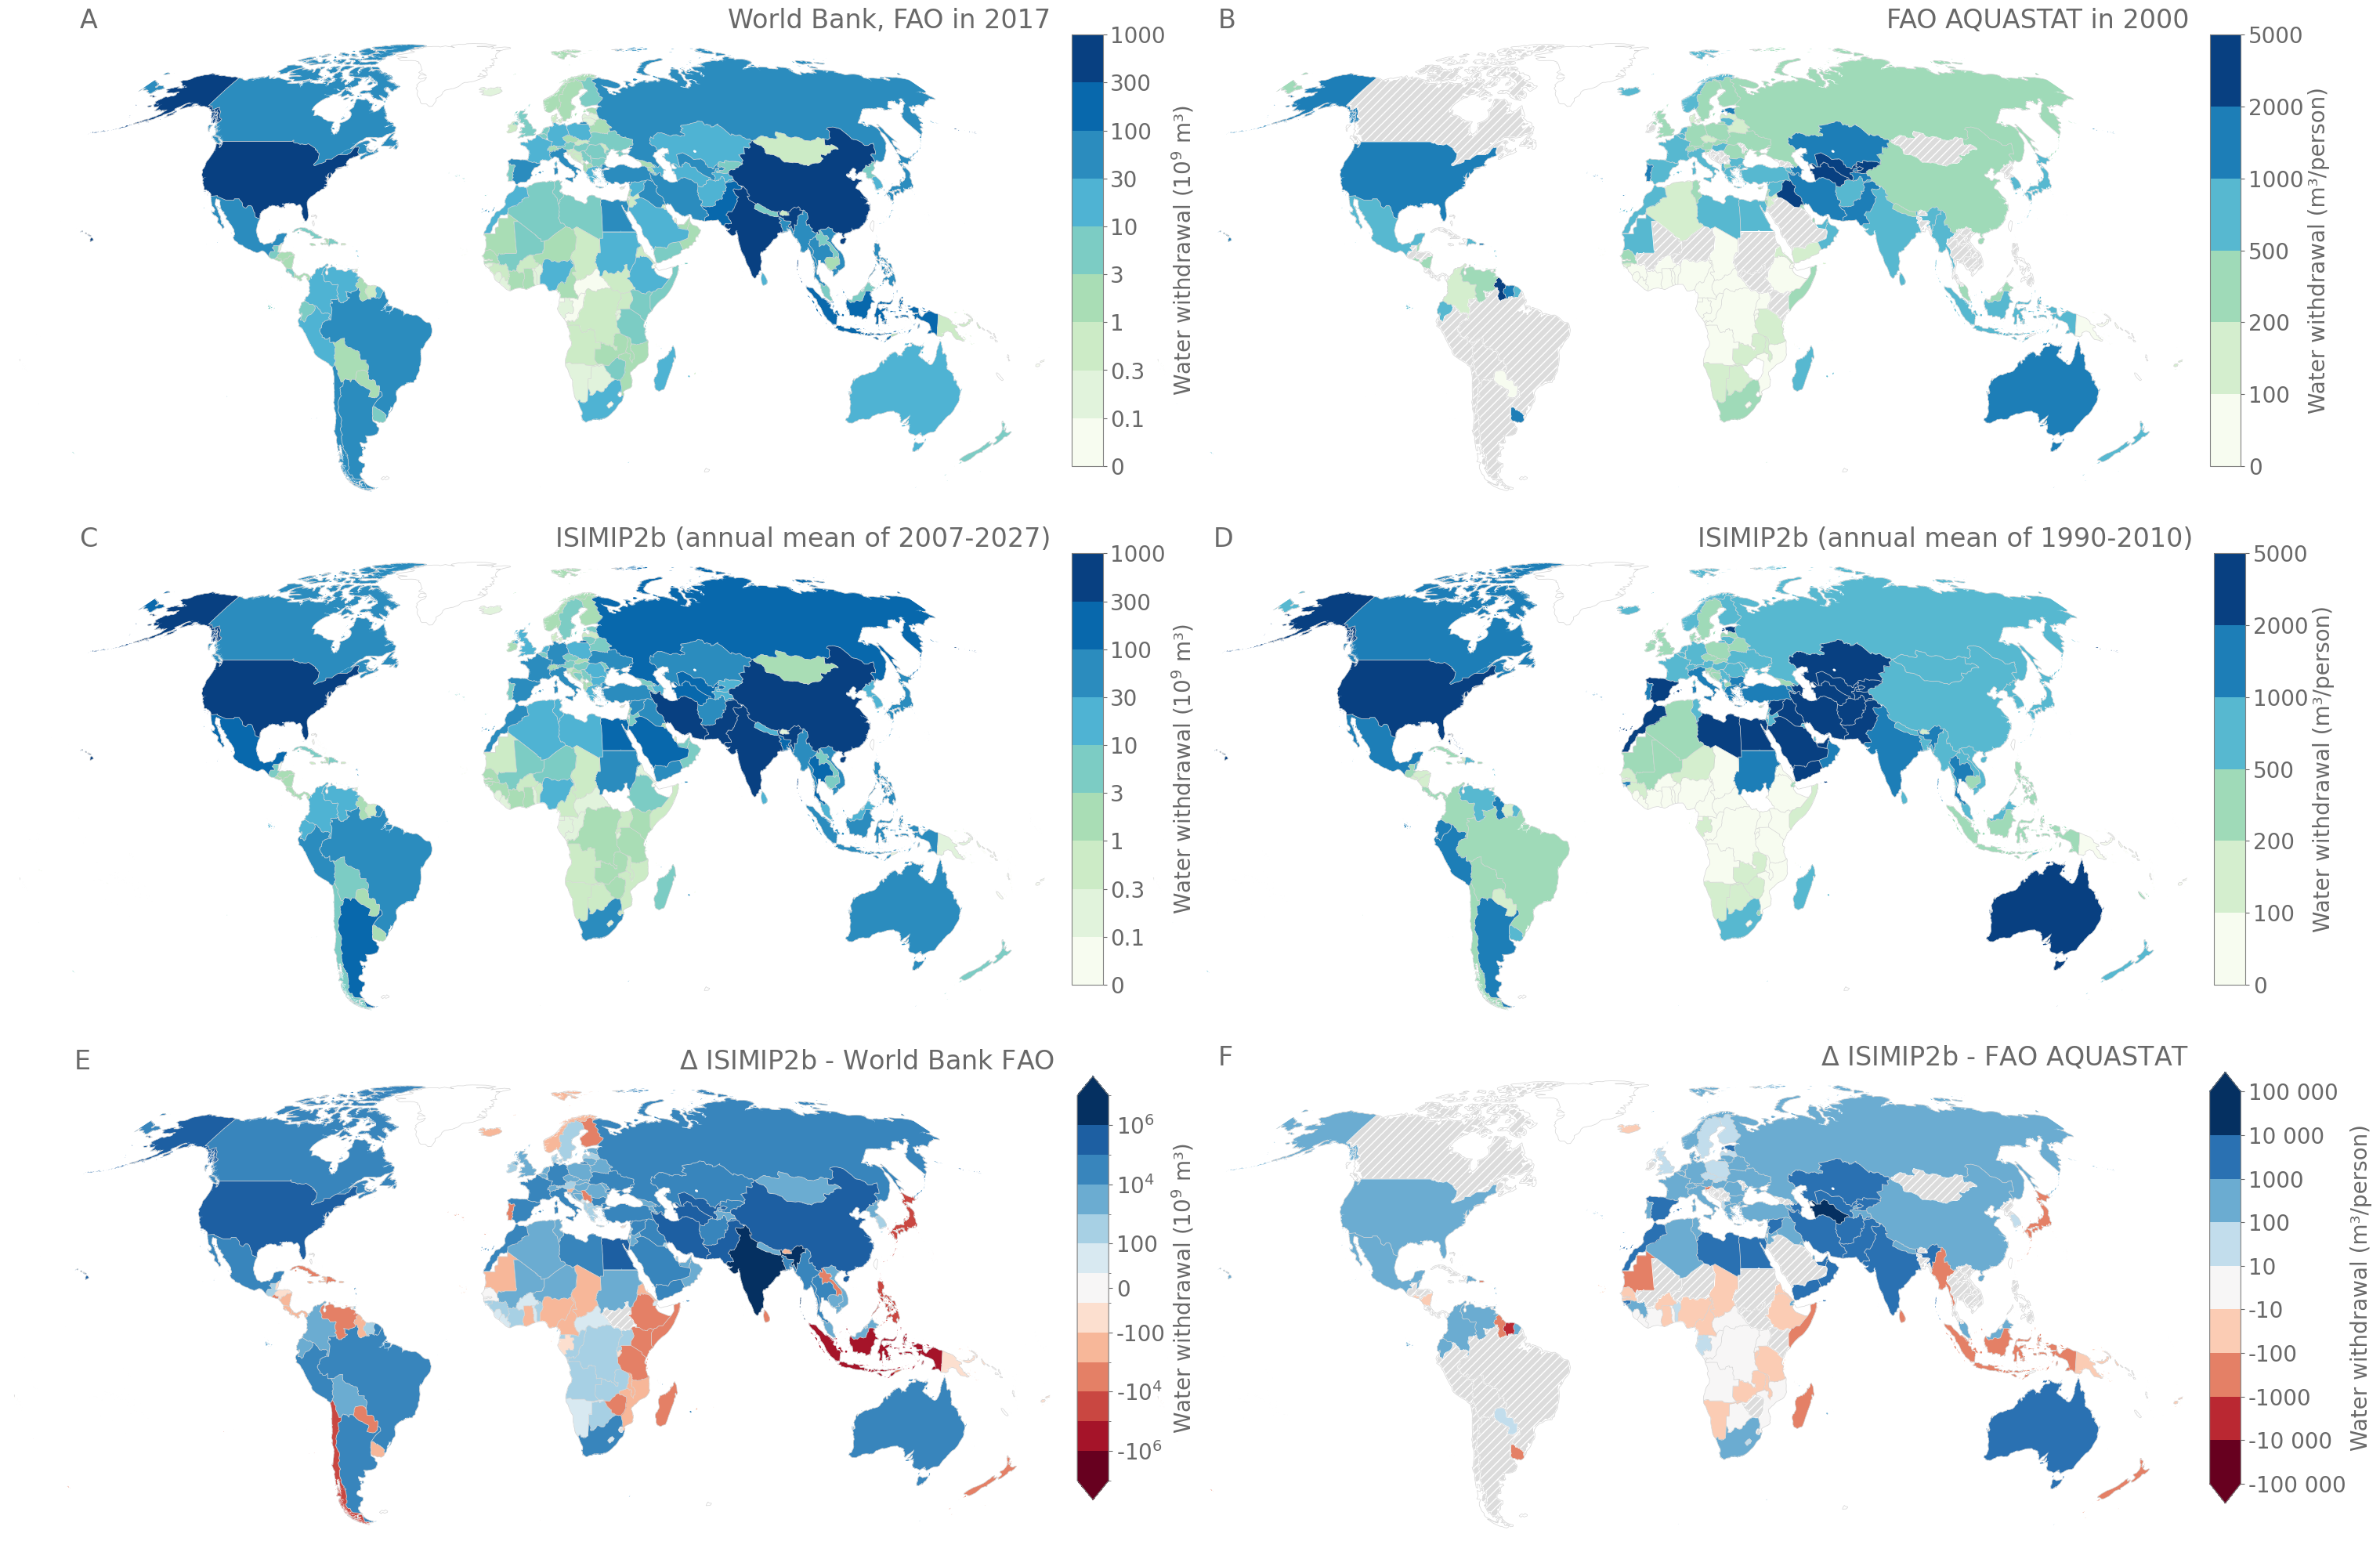

In [13]:
fig, axes = plt.subplots(3,2,figsize=(30,20), subplot_kw={'projection':map_proj})
offset = 10 # year (period to average isimip withdrawals on)

# -------------------------------------------------------------------------
# Plot total water withdrawal FAO 

ax = axes[0,0]
variable = 'Total water withdrawal (m$^3$)'

year = 2017

legend_label = "Water withdrawal (10$^9$ m³)"
title_text = 'World Bank, FAO in '+str(year)

bounds = [0,0.1,0.3,1,3,10,30,100,300,1000]
tick_labels = ['0','0.1','0.3','1','3','10','30','100','300','1000']

gdf_diff = gdf_country_borders.merge(df_totalww_obs, left_index=True, right_index=True)

ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='GnBu',  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256),
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label},  missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"})
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax.set_yticklabels(tick_labels)

ax.set_title(title_text, loc='right'); 
ax.set_title('        A', loc='left'); 

# -------------------------------------------------------------------------
# Plot total water withdrawal ISIMIP 

ax = axes[1,0]

legend_label = "Water withdrawal (10$^9$ m³)"
title_text = 'ISIMIP2b (annual mean of '+str(year-offset)+'-'+str(year+offset)+')'

bounds = [0,0.1,0.3,1,3,10,30,100,300,1000]
tick_labels = ['0','0.1','0.3','1','3','10','30','100','300','1000']

gdf_diff = gdf_country_borders.merge(df_totalww_mod, left_index=True, right_index=True)

ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); # make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='GnBu',  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256),
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"})
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax.set_yticklabels(tick_labels)

ax.set_title(title_text, loc='right'); 
ax.set_title('        C', loc='left'); 



# -------------------------------------------------------------------------
# Plot delta total water withdrawal 
ax = axes[2,0]


legend_label = "Water withdrawal (10$^9$ m³)"
title_text = '$\Delta$ ISIMIP2b - World Bank FAO '

df= diff_totalww * 1e-6
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)


bounds = [-1e7,-1e6,-1e5,-1e4,-1e3,-1e2,-1e1,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
ticks       = [-1e6,        -1e4,     -1e2, 0,  1e2,   1e4,     1e6]
tick_labels = ['-10$^6$','-10$^4$','-100','0', '100','10$^4$','10$^6$'];
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both'}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
cax.set_yticks(ticks)
#cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 
ax.set_title('        E', loc='left'); 
cax.set_yticklabels(tick_labels)



# -------------------------------------------------------------------------
# Plot  water withdrawal per capita world bank
year = 2000

ax = axes[0,1]

variable = 'Water withdrawal per capita (m$^3$)'

legend_label = "Water withdrawal (m³/person)"
title_text = 'FAO AQUASTAT in '+str(year)

bounds = [0,100,200,500,1000,2000,5000]

gdf_diff = gdf_country_borders.merge(df_percapita_obs, left_index=True, right_index=True)

ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='GnBu', norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256),
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"})
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

ax.set_title(title_text, loc='right'); 
ax.set_title('        B', loc='left'); 



# -------------------------------------------------------------------------
# Plot total water withdrawal per capita ISIMIP 
ax = axes[1,1]


legend_label = "Water withdrawal (m³/person)"
title_text = 'ISIMIP2b (annual mean of '+str(year-offset)+'-'+str(year+offset)+')'

bounds = [0,100,200,500,1000,2000,5000]

gdf_diff = gdf_country_borders.merge(df_percapita_mod, left_index=True, right_index=True)

ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='GnBu', norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256),
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"})
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

ax.set_title(title_text, loc='right'); 
ax.set_title('        D', loc='left'); 


# -------------------------------------------------------------------------
# Plot delta water withdrawal per capita

ax = axes[2,1]

legend_label = "Water withdrawal (m³/person)"
title_text = '$\Delta$ ISIMIP2b - FAO AQUASTAT'

df = diff_percapita
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

bounds = [-1e5,-1e4,-1e3,-100,-10,10,100, 1e3,1e4,1e5]
tick_labels = ['-100 000','-10 000','-1000','-100','-10','10','100', '1000','10 000','100 000']

ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both'}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 
ax.set_title('        F', loc='left'); 

fig.tight_layout()
plt.savefig('figures/evaluation.png', bbox_inches='tight',dpi=100)


## Water withdrawal per capita

Data published by	United Nations Food and Agricultural Organization (UN FAO) AQUASTAT Database
Link	http://www.fao.org/nr/water/aquastat/data/query/results.html
Retrieved	2017-11-05

Total water withdrawal: "Annual quantity of water withdrawn for agricultural, industrial and municipal purposes. It can include water from primary renewable and secondary freshwater resources, as well as water from over-abstraction of renewable groundwater or withdrawal from fossil groundwater, direct use of agricultural drainage water, direct use of (treated) wastewater, and desalinated water. It does not include in-stream uses, which are characterized by a very low net consumption rate, such as recreation, navigation, hydropower, inland capture fisheries, etc."



In [ ]:
ww_per_capita = load_process_csv(datadir+'water-withdrawals-per-capita.csv')
ww_per_capita.rename(columns=rename_countries, inplace=True) # m3

variable = 'Water withdrawal per capita (m$^3$)'
year = 2010

obs_ww = ww_per_capita
df = (obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Water withdrawal (m³/person)"
title_text = ' Water withdrawal per capita from FAO AQUASTAT in '+str(year)

bounds = [0,100,200,500,1000,2000,5000]

gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='Blues', norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256),
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label}, missing_kwds={"color": "white","edgecolor": "lightgrey", "hatch": "///"})
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)
ax.set_title(title_text, loc='right'); 


## NOT USED -- Renewable internal freshwater resources per capita

Data published by	World Development Indicators - World Bank (2022.05.26)
Data publisher's source	Food and Agriculture Organization of the United Nations


In [ ]:
wa_percapita = load_process_csv(datadir+'renewable-water-resources-per-capita.csv')
wa_percapita.rename(columns=rename_countries, inplace=True)
 # m3

In [ ]:
# plotting

variable = 'Water availability per capita (m$^3$)'
year = 2018

obs_ww = wa_percapita

df = (obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Water withdrawal (m³/person)"
title_text = ' Water withdrawal per capita from FAO AQUASTAT in '+str(year)

bounds = [0,500,1000,5000,10000,50000,100000,500000,1e6,5e6,10e6]
tick_labels = ['0','500','1000','5000','10000','50000','100000','500000','1e6','5e6','10e6']

gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis
cax.set_yticklabels(tick_labels)

ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='Blues', norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256),
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label}, missing_kwds={"color": "white","edgecolor": "lightgrey", "hatch": "///"}) # ,


# Compare modeled and observed water withdrawals per country

## Water withdrawal per capita

In [ ]:
variable = 'Water withdrawal per capita (m$^3$)'
year = 2000

mod_ww = df_withdrawal_percapita_mmm
obs_ww = ww_per_capita
diff = (mod_ww.loc[year] - obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Water withdrawal (m³/person)"
title_text = '$\Delta$ Water withdrawal ISIMIP2b - FAO AQUASTAT in '+str(year)

df= diff
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

bounds = [-1e5,-1e4,-1e3,-100,-10,10,100, 1e3,1e4,1e5]
tick_labels = ['-100 000','-10 000','-1000','-100','-10','10','100', '1000','10 000','100 000']

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both'}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 

In [ ]:
variable = 'Water withdrawal per capita (m$^3$)'
year = 2005

mod_ww = df_withdrawal_percapita_mmm
obs_ww = ww_per_capita
diff = (mod_ww.loc[year] - obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Water withdrawal (m³/person)"
title_text = '$\Delta$ Water withdrawal ISIMIP2b - FAO AQUASTAT in '+str(year)

df= diff
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

bounds = [-1e5,-1e4,-1e3,-100,-10,10,100, 1e3,1e4,1e5]
tick_labels = ['-100 000','-10 000','-1000','-100','-10','10','100', '1000','10 000','100 000']

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both'}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 

In [ ]:
variable = 'Water withdrawal per capita (m$^3$)'
year = 2010

mod_ww = df_withdrawal_percapita_mmm
obs_ww = ww_per_capita
diff = (mod_ww.loc[year] - obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Water withdrawal (m³/person)"
title_text = '$\Delta$ Water withdrawal ISIMIP2b - FAO AQUASTAT in '+str(year)

df= diff
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

bounds = [-1e5,-1e4,-1e3,-100,-10,10,100, 1e3,1e4,1e5]
tick_labels = ['-100 000','-10 000','-1000','-100','-10','10','100', '1000','10 000','100 000']

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both'}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 

##  $\Delta$ Total water withdrawal

In [ ]:
year = 2017
mod_ww = df_withdrawal_mmm 
obs_ww = ww 
diff = (mod_ww.loc[year-offset/2:year+offset/2].mean() - obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Total water withdrawal (million m³)"
title_text = '$\Delta$ Water withdrawal ISIMIP2b - World Bank FAO in '+str(year)

df= diff * 1e-6
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

bounds = [-1e7,-1e6,-1e5,-1e4,-1e3,-1e2,-1e1,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
ticks       = [-1e6,        -1e4,     -1e2, 0,  1e2,   1e4,     1e6]
tick_labels = ['-10$^6$','-10$^4$','-100','0', '100','10$^4$','10$^6$'];

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both', 'ticks':ticks}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
#cax.set_yticks(bounds)
#cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 

cax.set_yticklabels(tick_labels);


/data/brussel/100/vsc10055/miniconda3/envs/env_waterscarcity/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


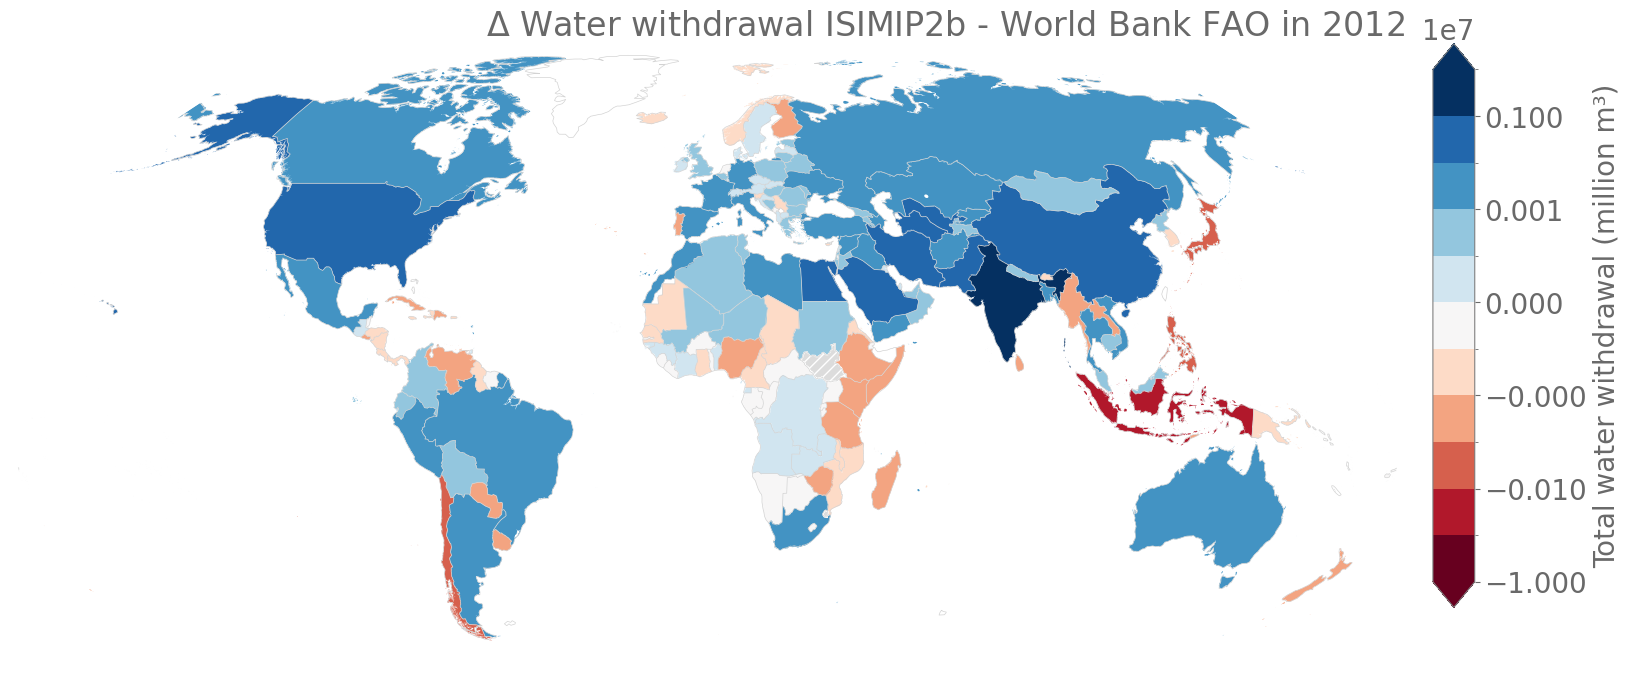

In [14]:
year = 2012
mod_ww = df_withdrawal_mmm 
obs_ww = ww 
diff = (mod_ww.loc[year] - obs_ww.loc[year].astype(float)).rename(variable).to_frame()

legend_label = "Total water withdrawal (million m³)"
title_text = '$\Delta$ Water withdrawal ISIMIP2b - World Bank FAO in '+str(year)

df= diff * 1e-6
gdf_diff = gdf_country_borders.merge(df, left_index=True, right_index=True)

bounds = [-1e7,-1e6,-1e5,-1e4,-1e3,-1e2,1e2,1e3,1e4,1e5,1e6,1e7]
#ticks = [-1e6,-1e4,-1e2,1e2,1e4,1e6]
#tick_labels = ['-1 000 000','-10 000','-100', '100','10 000',' 1 000 000']

fig, ax = plt.subplots(figsize=(18,10), subplot_kw={'projection':map_proj})
ax.axis('off')
ax.coastlines(color='lightgray',linewidth=0.5)
ax.add_feature(cfeature.BORDERS,color='lightgray',linewidth=0.5)

cax = ax.inset_axes((1.02, 0.1, 0.03, 0.9)); #make a color bar axis

gdf_diff.plot(ax=ax, column=variable, cax=cax,  legend=True, cmap='RdBu',
              transform=ccrs.PlateCarree(), legend_kwds={'label': legend_label, 'extend':'both'}, missing_kwds={"color": "gainsboro","edgecolor": "white", "hatch": "///"}, norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256))
#cax.set_yticks(ticks)
#cax.set_yticklabels(tick_labels)
ax.set_title(title_text, loc='right'); 

## Information on datasets

### Annual water withdrawal

Data published by: World Development Indicators - World Bank (2022.05.26)
Data publisher's source:	Food and Agriculture Organization of the United Nations

Annual freshwater withdrawals refer to total water withdrawals, not counting evaporation losses from storage basins. Withdrawals also include water from desalination plants in countries where they are a significant source. Withdrawals can exceed 100 percent of total renewable resources where extraction from nonrenewable aquifers or desalination plants is considerable or where there is significant water reuse. Withdrawals for agriculture and industry are total withdrawals for irrigation and livestock production and for direct industrial use (including withdrawals for cooling thermoelectric plants). Withdrawals for domestic uses include drinking water, municipal use or supply, and use for public services, commercial establishments, and homes. Data are for the most recent year available for 1987-2002.

Limitations and exceptions: A common perception is that most of the available freshwater resources are visible (on the surfaces of lakes, reservoirs and rivers). However, this visible water represents only a tiny fraction of global freshwater resources, as most of it is stored in aquifers, with the largest stocks stored in solid form in the Antarctic and in Greenland's ice cap.

Caution should also be used in comparing data on annual freshwater withdrawals, which are subject to variations in collection and estimation methods. In addition, inflows and outflows are estimated at different times and at different levels of quality and precision, requiring caution in interpreting the data, particularly for water-short countries, notably in the Middle East and North Africa.

The data are based on surveys and estimates provided by governments to the Joint Monitoring Programme of the World Health Organization (WHO) and the United Nations Children's Fund (UNICEF). The coverage rates are based on information from service users on actual household use rather than on information from service providers, which may include nonfunctioning systems.

Statistical concept and methodology: Annual freshwater withdrawals are total water withdrawals, not counting evaporation losses from storage basins. Withdrawals also include water from desalination plants in countries where they are a significant source. Water withdrawals can exceed 100 percent of total renewable resources where extraction from nonrenewable aquifers or desalination plants is considerable or where water reuse is significant. Withdrawals for agriculture and industry are total withdrawals for irrigation and livestock production and for direct industrial use (including for cooling thermoelectric plants). Withdrawals for domestic uses include drinking water, municipal use or supply, and use for public services, commercial establishments, and homes.

### Water withdrawal per capita

Data published by	United Nations Food and Agricultural Organization (UN FAO) AQUASTAT Database
Link	http://www.fao.org/nr/water/aquastat/data/query/results.html
Retrieved	2017-11-05
Data definitions for each variable included in the AQUASTAT Database is as follows:

Agricultural water withdrawal: "Annual quantity of self-supplied water withdrawn for irrigation, livestock and aquaculture purposes. It can include water from primary renewable and secondary freshwater resources, as well as water from over-abstraction of renewable groundwater or withdrawal from fossil groundwater, direct use of agricultural drainage water, direct use of (treated) wastewater, and desalinated water. Water for the dairy and meat industries and industrial processing of harvested agricultural products is included under industrial water withdrawal."

Industrial water withdrawal: "Annual quantity of self-supplied water withdrawn for industrial uses. It can include water from primary renewable and secondary freshwater resources, as well as water from over-abstraction of renewable groundwater or withdrawal from fossil groundwater, direct use of agricultural drainage water, direct use of (treated) wastewater, and desalinated water. This sector refers to self-supplied industries not connected to the public distribution network. The ratio between net consumption and withdrawal is estimated at less than 5%. It includes water for the cooling of thermoelectric and nuclear power plants, but it does not include hydropower. Water withdrawn by industries that are connected to the public supply network is generally included in municipal water withdrawal."

Municipal water withdrawal: "Annual quantity of water withdrawn primarily for the direct use by the population. It can include water from primary renewable and secondary freshwater resources, as well as water from over-abstraction of renewable groundwater or withdrawal from fossil groundwater, direct use of agricultural drainage water, direct use of (treated) wastewater, and desalinated water. It is usually computed as the total water withdrawn by the public distribution network. It can include that part of the industries and urban agriculture, which is connected to the municipal network. The ratio between the net consumption and the water withdrawn can vary from 5 to 15% in urban areas and from 10 to 50% in rural areas."

Irrigation water requirement: "The quantity of water exclusive of precipitation and soil moisture (i.e. quantity of irrigation water) required for normal crop production. It consists of water to ensure that the crop receives its full crop water requirement (i.e. irrigation consumptive water use, as well as extra water for flooding of paddy fields to facilitate land preparation and protect the plant and for leaching salt when necessary to allow for plant growth). It is usually expressed in water depth (millimetres) or water volume (m3) and may be stated in monthly, seasonal or annual terms, or for a crop period. It corresponds to net irrigation water requirement."

Irrigation water withdrawal: "Annual quantity of water withdrawn for irrigation purposes. In the AQUASTAT database water withdrawal for irrigation is part of agricultural water withdrawal, together with water withdrawal for livestock (watering and cleaning) and water withdrawal for aquaculture. It can include water from primary renewable and secondary freshwater resources, as well as water from over-abstraction of renewable groundwater or withdrawal from fossil groundwater, direct use of agricultural drainage water, direct use of (treated) wastewater, and desalinated water. The amount of water withdrawn for irrigation by far exceeds the consumptive use of irrigation because of water lost in its distribution from its source to the crops. The term "water requirement ratio" (sometimes also called "irrigation efficiency") is used to indicate the ratio between the net irrigation water requirements or crop water requirements, which is the volume of water needed to compensate for the deficit between potential evapotranspiration and effective precipitation over the growing period of the crop, and the amount of water withdrawn for irrigation including the losses. In the specific case of paddy rice irrigation, additional water is needed for flooding to facilitate land preparation and for plant protection. In that case, irrigation water requirements are the sum of rainfall deficit and the water needed to flood paddy fields. At scheme level, water requirement ratio values can vary from less than 20 percent to more than 80 percent."

Total water withdrawal: "Annual quantity of water withdrawn for agricultural, industrial and municipal purposes. It can include water from primary renewable and secondary freshwater resources, as well as water from over-abstraction of renewable groundwater or withdrawal from fossil groundwater, direct use of agricultural drainage water, direct use of (treated) wastewater, and desalinated water. It does not include in-stream uses, which are characterized by a very low net consumption rate, such as recreation, navigation, hydropower, inland capture fisheries, etc."


## RENEWABLE INTERNAL FRESHWATER RESOURCES PER CAPITA 

Renewable internal freshwater resources flows refer to internal renewable resources (internal river flows and groundwater from rainfall) in the country. Renewable internal freshwater resources per capita are calculated using the World Bank's population estimates.

Limitations and exceptions: A common perception is that most of the available freshwater resources are visible (on the surfaces of lakes, reservoirs and rivers). However, this visible water represents only a tiny fraction of global freshwater resources, as most of it is stored in aquifers, with the largest stocks stored in solid form in the Antarctic and in Greenland's ice cap.

The data on freshwater resources are based on estimates of runoff into rivers and recharge of groundwater. These estimates are based on different sources and refer to different years, so cross-country comparisons should be made with caution. Because the data are collected intermittently, they may hide significant variations in total renewable water resources from year to year. The data also fail to distinguish between seasonal and geographic variations in water availability within countries. Data for small countries and countries in arid and semiarid zones are less reliable than those for larger countries and countries with greater rainfall.

Caution should also be used in comparing data on annual freshwater withdrawals, which are subject to variations in collection and estimation methods. In addition, inflows and outflows are estimated at different times and at different levels of quality and precision, requiring caution in interpreting the data, particularly for water-short countries, notably in the Middle East and North Africa.

The data are based on surveys and estimates provided by governments to the Joint Monitoring Programme of the World Health Organization (WHO) and the United Nations Children's Fund (UNICEF). The coverage rates are based on information from service users on actual household use rather than on information from service providers, which may include nonfunctioning systems.

Statistical concept and methodology: Renewable water resources (internal and external) include average annual flow of rivers and recharge of aquifers generated from endogenous precipitation, and those water resources that are not generated in the country, such as inflows from upstream countries (groundwater and surface water), and part of the water of border lakes and/or rivers. Non-renewable water includes groundwater bodies (deep aquifers) that have a negligible rate of recharge on the human time-scale. While renewable water resources are expressed in flows, non-renewable water resources have to be expressed in quantity (stock). Runoff from glaciers where the mass balance is negative is considered non-renewable. Renewable internal freshwater resources per capita are calculated using the World Bank's population estimates. The unit of calculation is m3/year per inhabitant. Internal renewable freshwater resources per capita are calculated using the World Bank's population estimates.

Total actual renewable water resources correspond to the maximum theoretical yearly amount of water actually available for a country at a given moment. The unit of calculation is km3/year or 109 m3/year. Calculation Criteria is [Water resources: total renewable (actual)] = [Surface water: total renewable (actual)] + [Groundwater: total renewable (actual)] - [Overlap between surface water and groundwater].*

Fresh water is naturally occurring water on the Earth's surface. It is a renewable but limited natural resource. Fresh water can only be renewed through the process of the water cycle, where water from seas, lakes, forests, land, rivers, and dams evaporates, forms clouds, and returns as precipitation. However, if more fresh water is consumed through human activities than is restored by nature, the result is that the quantity of fresh water available in lakes, rivers, dams and underground waters can be reduced which can cause serious damage to the surrounding environment.

http://www.fao.org/nr/water/aquastat/data/glossary/search.html?termId=4188&submitBtn=s&cls=yes
Variable time span	1962 – 2018
Data published by	World Development Indicators - World Bank (2022.05.26)
Data publisher's source	Food and Agriculture Organization of the United Nations
Link	https://datacatalog.worldbank.org/search/dataset/0037712/World-Development-Indicators
Retrieved	2022-06-02

### 5.1 Convert Area Fraction Affected (AFA) to per-country number of extremes affecting one individual across life span

In [ ]:
df_countries['name']

In [ ]:
d_exposure_perrun_RCP     = {}
d_exposure_perrun_15      = {}
d_exposure_perrun_20      = {}
d_exposure_perrun_NDC     = {}
d_exposure_perrun_R26eval = {} 
d_cohort_exposure = {}

d_landfrac_peryear_perregion = {}
d_exposure_perregion_perrun_RCP = {}

# unpack region information
df_birthyears_regions = d_regions['birth_years']
d_cohort_weights_regions = d_regions['cohort_size']    
da_cohort_size = xr.DataArray(
    # np.asarray(list(d_cohort_size.values())),
    np.asarray([v for k,v in d_all_cohorts.items() if k in list(df_countries['name'])]),
    coords={
        'country': ('country', list(df_countries['name'])),
        'time': ('time', year_range),
        'ages': ('ages', np.arange(104,-1,-1)),
    },
    dims=[
        'country',
        'time',
        'ages',
    ]
)            

# loop over simulations
for i in [1]: #list(d_isimip_meta.keys()): 
    print('simulation '+str(i)+ ' of '+str(len(d_isimip_meta)))

    # load AFA data of that run
    with open('./data/pickles/isimip_AFA_{}_{}_{}.pkl'.format(d_isimip_meta[i]['extreme'],d_isimip_meta[i]['mode'],str(i)), 'rb') as f:
        da_AFA = pk.load(f)

    # --------------------------------------------------------------------
    # per country 

    # initialise dicts
    d_exposure_peryear_percountry = {}

    # get spatial average
    for j, country in enumerate(df_countries['name']):

        print('processing country '+str(j+1)+' of '+str(len(df_countries)), end='\r')

        # calculate mean per country weighted by population
        ind_country = countries_regions.map_keys(country)

        # historical + RCP simulations
        d_exposure_peryear_percountry[country] = calc_weighted_fldmean( 
            da_AFA,
            da_population, 
            countries_mask, 
            ind_country, 
            flag_region= False,
        )

    da_exposure_peryear_percountry = xr.DataArray(
        list(d_exposure_peryear_percountry.values()),
        coords={
            'country': ('country', list(d_exposure_peryear_percountry.keys())),
            'time': ('time', da_AFA.time.values),
        },
        dims=[
            'country',
            'time',
        ],
    )

    d_cohort_exposure[i]= da_exposure_peryear_percountry * da_cohort_size

    # --------------------------------------------------------------------
    # convert dict to dataframe for vectorizing and integrate exposures then map to GMTs        
    frame = {k:v.values for k,v in d_exposure_peryear_percountry.items()}
    df_exposure = pd.DataFrame(frame,index=np.arange(1960,2114))           

    # apply calc life exposure to columns (countries) of df_exposure
    d_exposure_perrun_RCP[i] = df_exposure.apply(
        lambda col: calc_life_exposure(
            df_exposure,
            df_life_expectancy_5,
            col.name,
        ),
        axis=0,
    )

    # if max threshold criteria met, run gmt mapping
    if d_isimip_meta[i]['GMT_15_valid']:

        d_exposure_perrun_15[i] = df_exposure.apply(
            lambda col: calc_life_exposure(
                df_exposure.reindex(df_exposure.index[d_isimip_meta[i]['ind_RCP2GMT_15']]).set_index(df_exposure.index),
                df_life_expectancy_5,
                col.name,
            ),
            axis=0,
        )

    if d_isimip_meta[i]['GMT_20_valid']:

        d_exposure_perrun_20[i] = df_exposure.apply(
            lambda col: calc_life_exposure(
                df_exposure.reindex(df_exposure.index[d_isimip_meta[i]['ind_RCP2GMT_20']]).set_index(df_exposure.index),
                df_life_expectancy_5,
                col.name,
            ),
            axis=0,
        )

    if d_isimip_meta[i]['GMT_NDC_valid']:

        d_exposure_perrun_NDC[i] = df_exposure.apply(
            lambda col: calc_life_exposure(
                df_exposure.reindex(df_exposure.index[d_isimip_meta[i]['ind_RCP2GMT_NDC']]).set_index(df_exposure.index),
                df_life_expectancy_5,
                col.name,
            ),
            axis=0,
        )

    if d_isimip_meta[i]['GMT_R26eval_valid']:

        d_exposure_perrun_R26eval[i] = df_exposure.apply(
            lambda col: calc_life_exposure(
                df_exposure.reindex(df_exposure.index[d_isimip_meta[i]['ind_RCP2GMT_R26eval']]).set_index(df_exposure.index),
                df_life_expectancy_5,
                col.name,
            ),
            axis=0,
        )

    # --------------------------------------------------------------------
    # per region
    #  

    print('')

    # initialise dictionaries
    d_landfrac_peryear_perregion[i] = {}
    d_exposure_perregion_RCP = {}

    # loop over regions
    for k, region in enumerate(df_birthyears_regions.columns): 

        print('processing region '+str(k+1)+' of '+str(len(df_birthyears_regions.columns)), end='\r')

        # Get list of member countries from region - with seperate treatment for world (luke: now inside get_countries_of_regions func)
        member_countries = get_countries_of_region(region, df_countries)

        # get spatial average of landfraction: historical + RCP simulations
        ind_countries = countries_regions.map_keys(member_countries)

        #print('calculating landfrac')
        d_landfrac_peryear_perregion[i][region] = calc_weighted_fldmean(
            da_AFA, 
            grid_area, 
            countries_mask, 
            ind_countries, 
            flag_region=True,
        )

        #print('calculating cohort weights')
        # filter cohort weights to only keep countries within mask 
        d_cohort_weights_regions[region] = d_cohort_weights_regions[region].loc[:,d_cohort_weights_regions[region].columns.isin(df_countries.index)]

        # get weighted spatial average for all member countries per region (Luke: but this is not necessarily spatial; d_cohorts_weights_regions has 2020 cohort sizes per country)
        d_exposure_perregion_RCP[region] = (d_exposure_perrun_RCP[i].loc[:,member_countries] * d_cohort_weights_regions[region].values).sum(axis=1) /\
            np.nansum(d_cohort_weights_regions[region].values, axis=1)

    print('')

    # save exposures for every run
    d_exposure_perregion_perrun_RCP[i]  = pd.DataFrame(d_exposure_perregion_RCP)

da_exposure_cohort = xr.concat(
    [v for v in d_cohort_exposure.values()],
    dim='runs',
).assign_coords({'runs':list(d_cohort_exposure.keys())})

# --------------------------------------------------------------------
# save workspave in pickles
#  

# save pickles
print()
print('Saving processed exposures')

# pack exposure information
d_exposure = {
    'exposure_perrun_RCP' : d_exposure_perrun_RCP, 
    'exposure_perrun_15' : d_exposure_perrun_15,
    'exposure_perrun_20' : d_exposure_perrun_20,
    'exposure_perrun_NDC' : d_exposure_perrun_NDC,
    'exposure_perregion_perrun_RCP' : d_exposure_perregion_perrun_RCP, 
    'landfrac_peryear_perregion' : d_landfrac_peryear_perregion,
    'exposure_per_cohort': da_exposure_cohort,
}

with open('./data/pickles/exposure_{}.pkl'.format(d_isimip_meta[i]['extreme']), 'wb') as f:
    pk.dump(d_exposure,f)



In [ ]:
if flags['mode']=='exposure':
    
    if flags['exposure'] == 1: 
    
        start_time = time.time()

        # calculate exposure per country and per region and save data (takes 23 mins)
        d_exposure_perrun_RCP, d_exposure_perregion_perrun_RCP, d_exposure_perrun_15, d_exposure_perrun_20, d_exposure_perrun_NDC, da_exposure_cohort = calc_exposure(
            grid_area,
            d_regions,
            d_isimip_meta, 
            df_birthyears_regions, 
            df_countries, 
            countries_regions, 
            countries_mask, 
            da_population, 
            df_life_expectancy_5,
            d_all_cohorts,
        )

        print("--- {} minutes ---".format(
            np.floor((time.time() - start_time) / 60),
            )
              )



    else: # load processed country data

        print('Loading processed exposures')

        # load country pickle
        with open('./data/pickles/exposure_{}_{}.pkl'.format(d_isimip_meta[list(d_isimip_meta.keys())[0]]['extreme'],d_isimip_meta[list(d_isimip_meta.keys())[0]]['mode']), 'rb') as f:
            d_exposure = pk.load(f)

        # unpack country information
        d_exposure_perrun_RCP = d_exposure['exposure_perrun_RCP']
        d_exposure_perrun_15 = d_exposure['exposure_perrun_15']
        d_exposure_perrun_20 = d_exposure['exposure_perrun_20']
        d_exposure_perrun_NDC = d_exposure['exposure_perrun_NDC']
        da_exposure_cohort = d_exposure['exposure_per_cohort']

        # unpack region information
        d_exposure_perregion_perrun_RCP = d_exposure['exposure_perregion_perrun_RCP']
        d_landfrac_peryear_perregion = d_exposure['landfrac_peryear_perregion']



